### Homework 05

Name: Yining Liu  
Github Username: Lynzz1701    
USC ID: 6168529797 

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing, metrics
from sklearn import tree
from sklearn.model_selection import cross_val_score,cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA

from xgboost import XGBRegressor

import os

import matplotlib.pyplot as plt
import seaborn as sns

### 1. Decision Trees as Interpretable Models

In [2]:
diagnosis = pd.read_csv('../data/diagnosis.data', encoding = "utf-16", 
                 names=['T','1','2','3','4','5','d1','d2'], 
                 sep = '\t', decimal=",")
diagnosis.iloc[:, 1:8] = diagnosis.iloc[:, 1:8].eq('yes').mul(1)
diagnosis

,T,1,2,3,4,5,d1,d2
0,35.5,0,1,0,0,0,0,0
1,35.9,0,0,1,1,1,1,0
2,35.9,0,1,0,0,0,0,0
3,36.0,0,0,1,1,1,1,0
4,36.0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...
115,41.4,0,1,1,0,1,0,1
116,41.5,0,0,0,0,0,0,0
117,41.5,1,1,0,1,0,0,1
118,41.5,0,1,1,0,1,0,1


#### 1(b) Build a decision tree on the whole data set and plot it

[Text(0.4, 0.9, 'Temperature <= 37.95\ngini = 0.493\nsamples = 120\nvalue = [[61, 59]\n[70, 50]]'),
 Text(0.2, 0.7, 'Urine pushing <= 0.5\ngini = 0.222\nsamples = 60\nvalue = [[20, 40]\n[60, 0]]'),
 Text(0.1, 0.5, 'gini = 0.0\nsamples = 20\nvalue = [[20, 0]\n[20, 0]]'),
 Text(0.3, 0.5, 'gini = 0.0\nsamples = 40\nvalue = [[0, 40]\n[40, 0]]'),
 Text(0.6, 0.7, 'Lumbar pain <= 0.5\ngini = 0.355\nsamples = 60\nvalue = [[41, 19]\n[10, 50]]'),
 Text(0.5, 0.5, 'gini = 0.0\nsamples = 10\nvalue = [[10, 0]\n[10, 0]]'),
 Text(0.7, 0.5, 'Micturition pains <= 0.5\ngini = 0.236\nsamples = 50\nvalue = [[31, 19]\n[0, 50]]'),
 Text(0.6, 0.3, 'gini = 0.0\nsamples = 21\nvalue = [[21, 0]\n[0, 21]]'),
 Text(0.8, 0.3, 'Urine pushing <= 0.5\ngini = 0.226\nsamples = 29\nvalue = [[10, 19]\n[0, 29]]'),
 Text(0.7, 0.1, 'gini = 0.0\nsamples = 10\nvalue = [[10, 0]\n[0, 10]]'),
 Text(0.9, 0.1, 'gini = 0.0\nsamples = 19\nvalue = [[0, 19]\n[0, 19]]')]

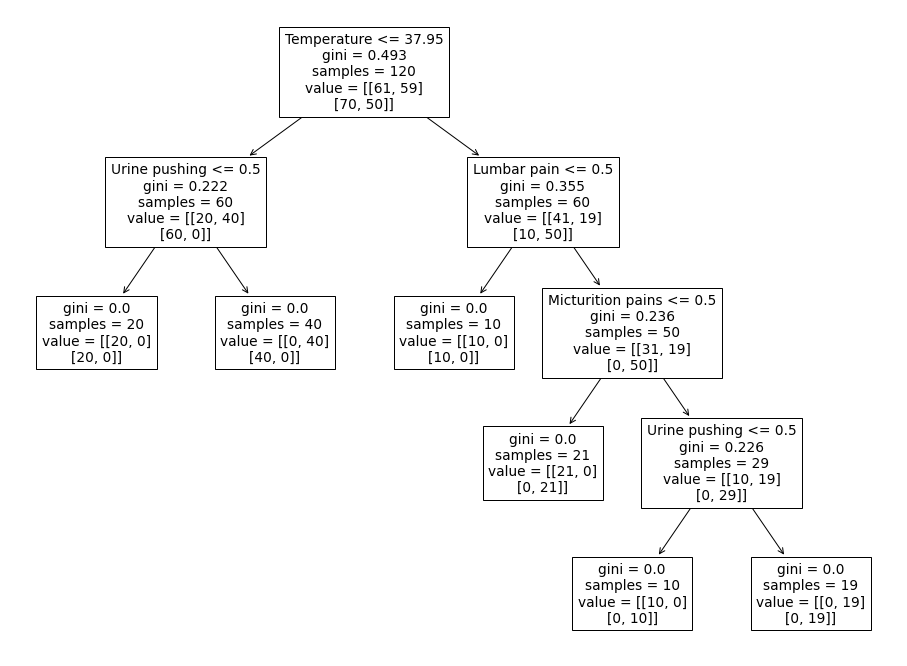

In [3]:
X = diagnosis.iloc[:, :6]
y = diagnosis.iloc[:, 6:]

#criterion = gini & entropy yield same result for this 
dt = tree.DecisionTreeClassifier()
dt.fit(X,y)
#dt2 = tree.DecisionTreeClassifier(criterion='entropy')
#dt2.fit(X,y)

features = ['Temperature','Occurrence of nausea','Lumbar pain','Urine pushing','Micturition pains']
#d1 decision: Inflammation of urinary bladder { yes, no }
#d2 decision: Nephritis of renal pelvis origin { yes, no } 
plt.figure(figsize=(16,12)) 
tree.plot_tree(dt, feature_names=features)

#### 1(c)  Convert the decision rules into a set of IF-THEN rules.

In [4]:
def tree_to_pseudo(tree, feature_names):
        print("IF-THEN pseudo code:")
        print("d1 decision: Inflammation of urinary bladder { no, yes }")
        print("d2 decision: Nephritis of renal pelvis origin { no, yes }\n")
    
        '''
        Outputs a decision tree model as if/then pseudocode
        Parameters:
        -----------
        tree: decision tree model
                The decision tree to represent as pseudocode
        feature_names: list
                The feature names of the dataset used for building the decision tree
        '''
        
        left = tree.tree_.children_left
        right = tree.tree_.children_right
        threshold = tree.tree_.threshold
        features = [feature_names[i] for i in tree.tree_.feature]
        value = tree.tree_.value
        
        def recurse(left, right, threshold, features, node, depth=0): 
            indent=" "*depth
            if (threshold[node] != -2):
                print(indent,"if (" + features[node] + " <= " + str('%.2f'%threshold[node]) + ") {")#2-digits
                if left[node] != -1:
                    recurse(left, right, threshold, features, left[node], depth+1)
                    print(indent,"} else {")
                    if right[node] != -1:
                        recurse (left, right, threshold, features, right[node], depth+1)
                    print(indent,"}")
            else:
                    print(indent,"return " + str(value[node][0]) + str(value[node][1]))#multi-label
                        
        recurse(left, right, threshold, features, 0)
        
tree_to_pseudo(dt,features)

IF-THEN pseudo code:
d1 decision: Inflammation of urinary bladder { no, yes }
d2 decision: Nephritis of renal pelvis origin { no, yes }

 if (Temperature <= 37.95) {
  if (Urine pushing <= 0.50) {
   return [20.  0.][20.  0.]
  } else {
   return [ 0. 40.][40.  0.]
  }
 } else {
  if (Lumbar pain <= 0.50) {
   return [10.  0.][10.  0.]
  } else {
   if (Micturition pains <= 0.50) {
    return [21.  0.][ 0. 21.]
   } else {
    if (Urine pushing <= 0.50) {
     return [10.  0.][ 0. 10.]
    } else {
     return [ 0. 19.][ 0. 19.]
    }
   }
  }
 }


#### 1(d) Use cost-complexity pruning to find a minimal decision tree and a set of decision rules with high interpretability.

In [5]:
#refer to https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html
path = dt.cost_complexity_pruning_path(X, y)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
print('effective alphas:', list(ccp_alphas),'\n')

for ccp_alpha in ccp_alphas:
    clf = tree.DecisionTreeClassifier(ccp_alpha=ccp_alpha)
    print('ccp_alpha =', ccp_alpha)
    cv_score = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
    print(cv_score)
    print('mean:', cv_score.mean())

effective alphas: [0.0, 0.04908333333333333, 0.07947222222222226, 0.1111111111111111, 0.204236111111111] 

ccp_alpha = 0.0
[1.   1.   0.75 1.   1.  ]
mean: 0.95
ccp_alpha = 0.04908333333333333
[1.         1.         0.66666667 0.33333333 0.70833333]
mean: 0.7416666666666667
ccp_alpha = 0.07947222222222226
[1.         1.         0.66666667 0.33333333 0.54166667]
mean: 0.7083333333333333
ccp_alpha = 0.1111111111111111
[0.54166667 0.75       0.66666667 0.33333333 0.54166667]
mean: 0.5666666666666667
ccp_alpha = 0.204236111111111
[0.54166667 0.         0.125      0.33333333 0.        ]
mean: 0.2


- alpha=0.0 yields the best accuracy in cv. Classifier & decision rules remain the same as previous.

IF-THEN pseudo code:
d1 decision: Inflammation of urinary bladder { no, yes }
d2 decision: Nephritis of renal pelvis origin { no, yes }

 if (Temperature <= 37.95) {
  return [20. 40.][60.  0.]
 } else {
  return [41. 19.][10. 50.]
 }


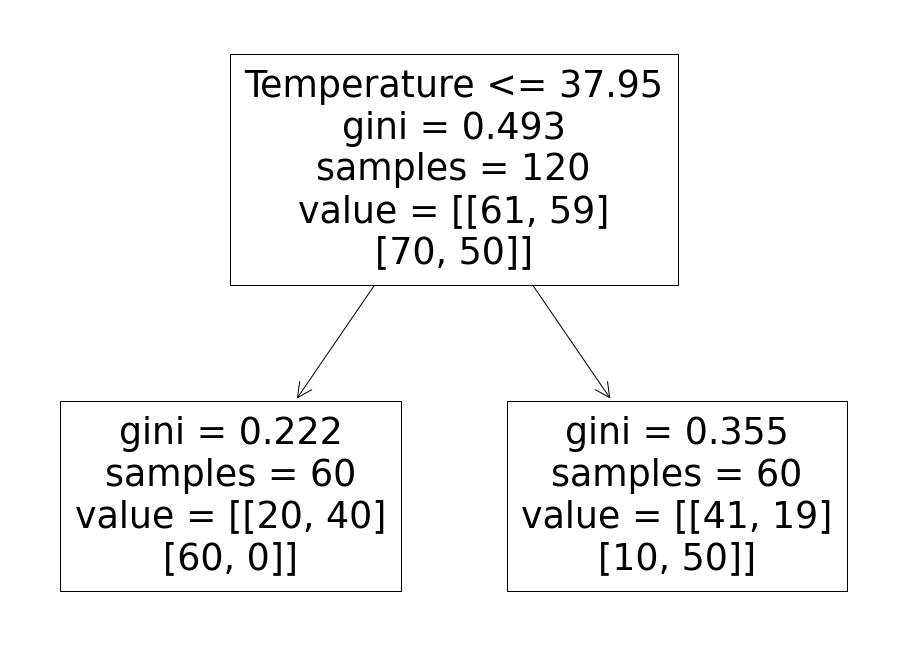

In [6]:
min_dt = tree.DecisionTreeClassifier(ccp_alpha=0.2042361111111)
min_dt.fit(X,y)
plt.figure(figsize=(16,12)) 
tree.plot_tree(min_dt, feature_names=features)
tree_to_pseudo(min_dt,features)

### 2. The LASSO and Boosting for Regression

#### 2(a) Download the Communities and Crime data. Use the first 1495 rows of data as the training set and the rest as the test set.

In [7]:
communities = pd.read_csv('../data/communities.csv', header=None)
communities.replace('?', np.nan, inplace=True) #preparation for imputation
communities

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,8,NaN,NaN,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,...,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,53,NaN,NaN,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,...,0.02,0.12,0.45,NaN,NaN,NaN,NaN,0.00,NaN,0.67
2,24,NaN,NaN,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,...,0.01,0.21,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.43
3,34,5,81440,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,...,0.02,0.39,0.28,NaN,NaN,NaN,NaN,0.00,NaN,0.12
4,42,95,6096,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,...,0.04,0.09,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,12,NaN,NaN,TempleTerracecity,10,0.01,0.40,0.10,0.87,0.12,...,0.01,0.28,0.05,NaN,NaN,NaN,NaN,0.00,NaN,0.09
1990,6,NaN,NaN,Seasidecity,10,0.05,0.96,0.46,0.28,0.83,...,0.02,0.37,0.20,NaN,NaN,NaN,NaN,0.00,NaN,0.45
1991,9,9,80070,Waterburytown,10,0.16,0.37,0.25,0.69,0.04,...,0.08,0.32,0.18,0.08,0.06,0.78,0,0.91,0.28,0.23
1992,25,17,72600,Walthamcity,10,0.08,0.51,0.06,0.87,0.22,...,0.03,0.38,0.33,0.02,0.02,0.79,0,0.22,0.18,0.19


In [8]:
train = communities.iloc[:1495]
test = communities.iloc[1495:]

#### 2(b) The data set has missing values. Use a data imputation technique to deal with the missing values in the data set. 

In [9]:
#not_ordinal = [i for i in range(4,128) if i!=124]
features = [i for i in range(4,128)]

# [0,1] cuz data are normalized
imp_mean = IterativeImputer(random_state=13, skip_complete=True, max_iter=1000, min_value=0, max_value=1)
imp_mean.fit(train.iloc[:,features])

df_train = pd.DataFrame(imp_mean.transform(train.iloc[:, features]),columns = features)
df_test = pd.DataFrame(imp_mean.transform(test.iloc[:, features]),columns = features)

In [10]:
df_train

,4,5,6,7,8,9,10,11,12,13,...,118,119,120,121,122,123,124,125,126,127
0,1.0,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,...,0.12,0.26,0.20,0.060000,0.040000,0.900000,0.500000,0.32,0.140000,0.20
1,1.0,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,...,0.02,0.12,0.45,0.056069,0.053569,0.758161,0.621486,0.00,0.252890,0.67
2,1.0,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,...,0.01,0.21,0.02,0.124346,0.048972,0.706787,0.484352,0.00,0.298026,0.43
3,1.0,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,0.34,...,0.02,0.39,0.28,0.085551,0.081577,0.667937,0.405008,0.00,0.248067,0.12
4,1.0,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,0.23,...,0.04,0.09,0.02,0.047008,0.031101,0.738933,0.329330,0.00,0.196094,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1490,8.0,0.00,0.59,0.01,0.69,1.00,0.07,0.41,0.28,0.23,...,0.02,0.14,0.22,0.000000,0.008946,0.702207,0.362394,0.00,0.207102,0.03
1491,8.0,0.16,0.62,0.03,0.74,0.48,0.42,0.44,0.57,0.40,...,0.07,0.40,0.14,0.070000,0.050000,0.850000,0.500000,0.61,0.190000,0.20
1492,8.0,0.01,0.36,0.95,0.24,0.03,0.01,0.44,0.42,0.27,...,0.03,0.12,0.01,0.100857,0.047003,0.569275,0.487144,0.00,0.152855,0.30
1493,8.0,0.06,0.53,0.01,0.98,0.05,0.01,0.40,0.40,0.24,...,0.08,0.15,0.02,0.081717,0.137026,0.672098,0.353987,0.00,0.232638,0.03


In [11]:
df_test

,4,5,6,7,8,9,10,11,12,13,...,118,119,120,121,122,123,124,125,126,127
0,8.0,0.00,0.20,0.03,0.91,0.23,0.05,0.15,0.19,0.09,...,0.01,0.23,0.73,0.020339,0.044753,0.727570,0.456855,0.00,0.306233,0.12
1,8.0,0.00,0.55,0.13,0.78,0.15,0.36,0.48,0.53,0.30,...,0.01,0.18,0.02,0.069844,0.112614,0.669429,0.400600,0.00,0.141331,0.11
2,8.0,0.00,0.52,0.04,0.59,0.05,0.62,0.84,0.78,0.75,...,0.01,0.18,0.00,0.095837,0.071296,0.675892,0.531684,0.00,0.149664,0.12
3,8.0,0.04,0.51,0.07,0.92,0.09,0.03,0.38,0.47,0.27,...,0.06,0.13,0.16,0.038487,0.055321,0.674635,0.345044,0.00,0.188254,0.06
4,8.0,0.03,0.59,0.20,0.75,0.19,0.10,0.38,0.62,0.35,...,0.03,0.23,0.06,0.072051,0.070176,0.638147,0.469047,0.00,0.229460,0.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494,10.0,0.01,0.40,0.10,0.87,0.12,0.16,0.43,0.51,0.35,...,0.01,0.28,0.05,0.049123,0.038387,0.653385,0.478442,0.00,0.190127,0.09
495,10.0,0.05,0.96,0.46,0.28,0.83,0.32,0.69,0.86,0.73,...,0.02,0.37,0.20,0.088293,0.101027,0.611463,0.569584,0.00,0.294903,0.45
496,10.0,0.16,0.37,0.25,0.69,0.04,0.25,0.35,0.50,0.31,...,0.08,0.32,0.18,0.080000,0.060000,0.780000,0.000000,0.91,0.280000,0.23
497,10.0,0.08,0.51,0.06,0.87,0.22,0.10,0.58,0.74,0.63,...,0.03,0.38,0.33,0.020000,0.020000,0.790000,0.000000,0.22,0.180000,0.19


- extra processing for imputed data

In [12]:
#LemasGangUnitDeploy: gang unit deployed 
#(numeric - decimal - but really ordinal - 0 means NO, 1 means YES, 0.5 means Part Time)
ordinal_train = []
for i in list(df_train[124]):
    if i <= 0.5:
        if i <= (0.5-i):
            ordinal_train.append(0)
        else:
            ordinal_train.append(0.5)
    else:
        if (i-0.5) <= (1-i):
            ordinal_train.append(0.5)
        else:
            ordinal_train.append(1)

ordinal_test = []
for i in list(df_test[124]):
    if i <= 0.5:
        if i <= (0.5-i):
            ordinal_test.append(0)
        else:
            ordinal_test.append(0.5)
    else:
        if (i-0.5) <= (1-i):
            ordinal_test.append(0.5)
        else:
            ordinal_test.append(1)
            
df_train[124] = ordinal_train
df_test[124] = ordinal_test

In [13]:
df_train

,4,5,6,7,8,9,10,11,12,13,...,118,119,120,121,122,123,124,125,126,127
0,1.0,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,...,0.12,0.26,0.20,0.060000,0.040000,0.900000,0.5,0.32,0.140000,0.20
1,1.0,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,...,0.02,0.12,0.45,0.056069,0.053569,0.758161,0.5,0.00,0.252890,0.67
2,1.0,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,...,0.01,0.21,0.02,0.124346,0.048972,0.706787,0.5,0.00,0.298026,0.43
3,1.0,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,0.34,...,0.02,0.39,0.28,0.085551,0.081577,0.667937,0.5,0.00,0.248067,0.12
4,1.0,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,0.23,...,0.04,0.09,0.02,0.047008,0.031101,0.738933,0.5,0.00,0.196094,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1490,8.0,0.00,0.59,0.01,0.69,1.00,0.07,0.41,0.28,0.23,...,0.02,0.14,0.22,0.000000,0.008946,0.702207,0.5,0.00,0.207102,0.03
1491,8.0,0.16,0.62,0.03,0.74,0.48,0.42,0.44,0.57,0.40,...,0.07,0.40,0.14,0.070000,0.050000,0.850000,0.5,0.61,0.190000,0.20
1492,8.0,0.01,0.36,0.95,0.24,0.03,0.01,0.44,0.42,0.27,...,0.03,0.12,0.01,0.100857,0.047003,0.569275,0.5,0.00,0.152855,0.30
1493,8.0,0.06,0.53,0.01,0.98,0.05,0.01,0.40,0.40,0.24,...,0.08,0.15,0.02,0.081717,0.137026,0.672098,0.5,0.00,0.232638,0.03


In [14]:
df_test

,4,5,6,7,8,9,10,11,12,13,...,118,119,120,121,122,123,124,125,126,127
0,8.0,0.00,0.20,0.03,0.91,0.23,0.05,0.15,0.19,0.09,...,0.01,0.23,0.73,0.020339,0.044753,0.727570,0.5,0.00,0.306233,0.12
1,8.0,0.00,0.55,0.13,0.78,0.15,0.36,0.48,0.53,0.30,...,0.01,0.18,0.02,0.069844,0.112614,0.669429,0.5,0.00,0.141331,0.11
2,8.0,0.00,0.52,0.04,0.59,0.05,0.62,0.84,0.78,0.75,...,0.01,0.18,0.00,0.095837,0.071296,0.675892,0.5,0.00,0.149664,0.12
3,8.0,0.04,0.51,0.07,0.92,0.09,0.03,0.38,0.47,0.27,...,0.06,0.13,0.16,0.038487,0.055321,0.674635,0.5,0.00,0.188254,0.06
4,8.0,0.03,0.59,0.20,0.75,0.19,0.10,0.38,0.62,0.35,...,0.03,0.23,0.06,0.072051,0.070176,0.638147,0.5,0.00,0.229460,0.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494,10.0,0.01,0.40,0.10,0.87,0.12,0.16,0.43,0.51,0.35,...,0.01,0.28,0.05,0.049123,0.038387,0.653385,0.5,0.00,0.190127,0.09
495,10.0,0.05,0.96,0.46,0.28,0.83,0.32,0.69,0.86,0.73,...,0.02,0.37,0.20,0.088293,0.101027,0.611463,0.5,0.00,0.294903,0.45
496,10.0,0.16,0.37,0.25,0.69,0.04,0.25,0.35,0.50,0.31,...,0.08,0.32,0.18,0.080000,0.060000,0.780000,0.0,0.91,0.280000,0.23
497,10.0,0.08,0.51,0.06,0.87,0.22,0.10,0.58,0.74,0.63,...,0.03,0.38,0.33,0.020000,0.020000,0.790000,0.0,0.22,0.180000,0.19


#### 2(c) Plot a correlation matrix for the features in the data set.

          4         5         6         7         8         9         10   \
4    1.000000 -0.006670  0.040634  0.008585 -0.016408 -0.002880  0.011776   
5   -0.006670  1.000000 -0.040404  0.242144 -0.306023  0.168868  0.162282   
6    0.040634 -0.040404  1.000000 -0.068374 -0.243565  0.209848  0.473320   
7    0.008585  0.242144 -0.068374  1.000000 -0.793431 -0.104912 -0.069449   
8   -0.016408 -0.306023 -0.243565 -0.793431  1.000000 -0.270829 -0.436737   
..        ...       ...       ...       ...       ...       ...       ...   
122 -0.003753  0.624034  0.069281  0.060667 -0.151252  0.122748  0.164769   
123 -0.235211 -0.028955 -0.121071 -0.293156  0.251355  0.090257 -0.021786   
124  0.011276  0.004650  0.037051  0.036356 -0.069342  0.032810  0.055510   
125 -0.045074  0.464459 -0.086315  0.257781 -0.272366  0.100653  0.126210   
126 -0.057451 -0.096498  0.148373 -0.177424  0.081616  0.125387  0.093585   

          11        12        13   ...       117       118       119  \
4  

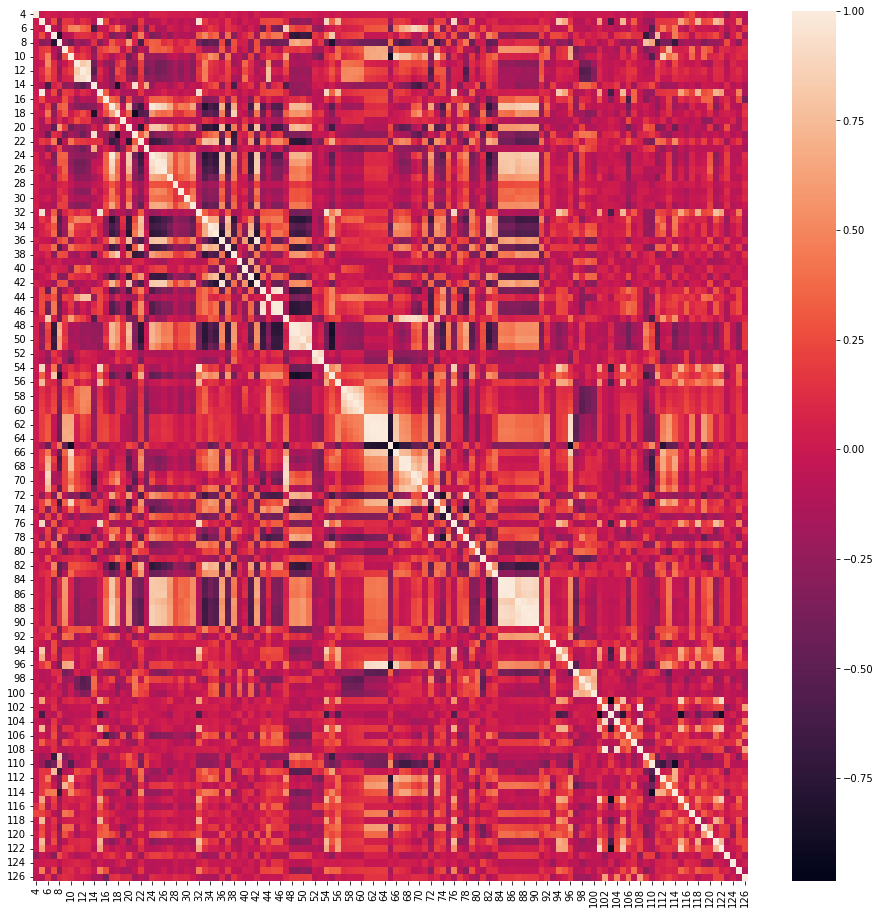

In [15]:
corrMatrix_train = df_train.iloc[:,:-1].corr()
print(corrMatrix_train)
plt.figure(figsize=(16,16)) 
sns.heatmap(corrMatrix_train)
plt.show()

#### 2(d) Calculate the Coefficient of Variation CV for each feature, where CV = ms , in which s is sample standard deviation and m is sample mean.

In [16]:
cv = lambda x: np.std(x) / np.mean(x)
df_cvs = pd.DataFrame(df_train.iloc[:,:-1].apply(cv),columns=['cv'])
df_cvs

,cv
4,0.510131
5,2.240355
6,0.355681
7,1.428407
8,0.330102
...,...
122,1.097262
123,0.129309
124,0.387860
125,2.552092


#### 2(e) Pick floor(sqrt(128)) features with highest CV , and make scatter plots and box plots for them.

In [17]:
df_cvs.nlargest(11,'cv')

,cv
95,4.291487
94,3.469791
54,3.057941
56,2.925656
115,2.741116
125,2.552092
32,2.341660
5,2.240355
15,2.037780
105,1.995450


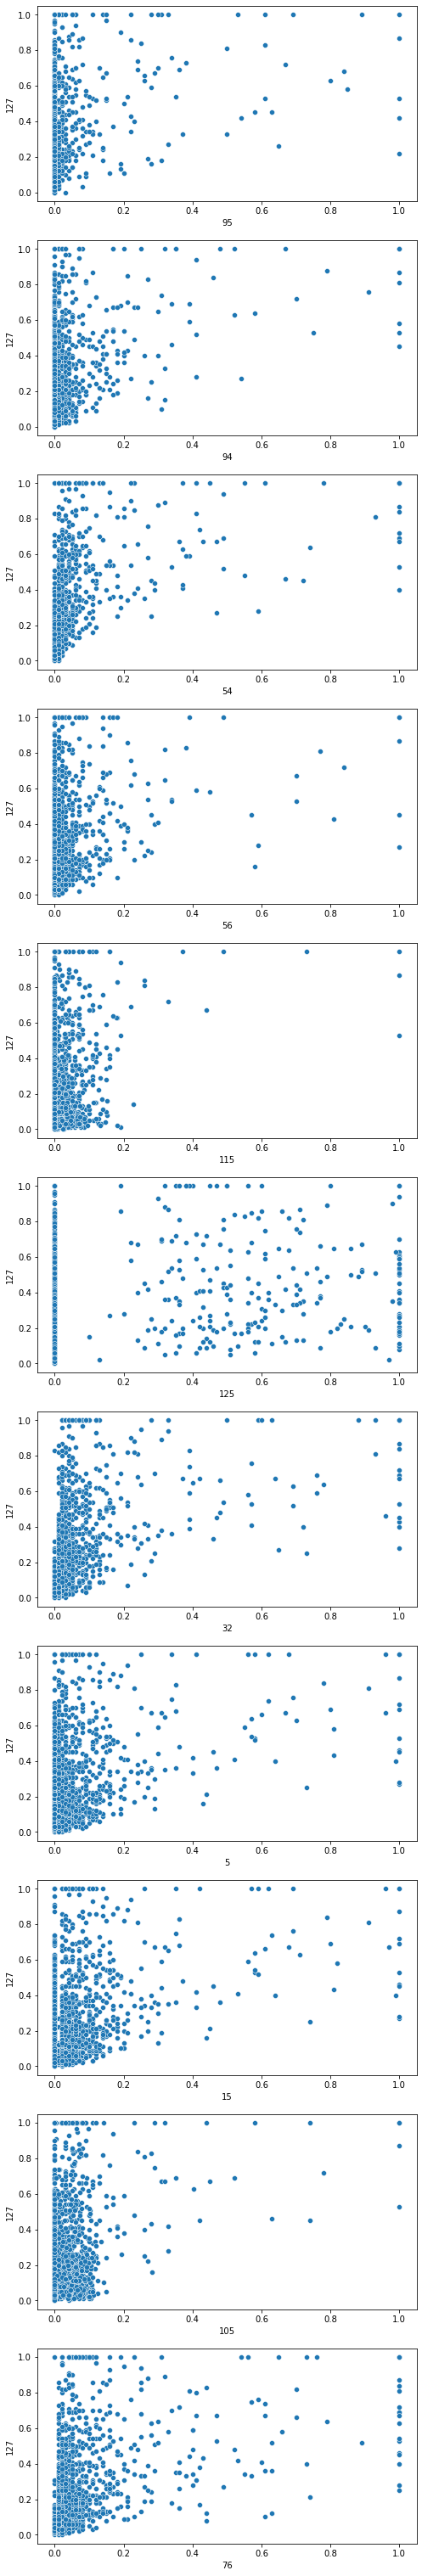

In [18]:
selected_features = [95, 94, 54, 56, 115, 125, 32, 5, 15, 105, 76]
fig, axes = plt.subplots(11,1,figsize=(8,55))
for i in range(11):
    sns.scatterplot(ax=axes[i],data=df_train, x=selected_features[i],y=127)
    #sns.boxplot(ax=axes[i,1],data=df_train,x=127, y=selected_features[i],orient='v')
#fig.tight_layout()

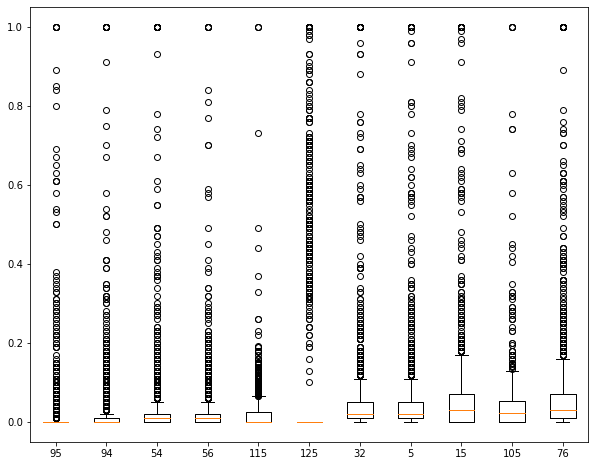

In [19]:
fig = plt.figure(figsize =(10, 8))
boxplot = plt.boxplot(df_train[selected_features])
boxplot = plt.xticks([i for i in range(1,12)], selected_features)

#### Can you draw conclusions about significance of those features, just by the scatter plots?

- those features have rather small ranges of values , most of their values are close to 0, except for feature#125 which has two poles (both 0 & 1).

- They seem to spread out the y-axis regardless of target(#127).

- Higher CV usually indicates higher variance over the mean.

- They are of less sigificance compared to other features.

#### 2(f) Fit a linear model using least squares to the training set and report the test error.

In [20]:
X_train, y_train = df_train.iloc[:,:-1], df_train[127]
X_test, y_test = df_test.iloc[:,:-1], df_test[127]

In [21]:
reg_ls = LinearRegression().fit(X_train, y_train)
preds_ls = reg_ls.predict(X_test)
mse_ls = mean_squared_error(y_test, preds_ls)
print('test MSE for least squares linear model =', mse_ls)

test MSE for least squares linear model = 1101.9122301148252


#### 2(g) Fit a ridge regression model on the training set, with λ chosen by cross-validation. Report the test error obtained.

In [22]:
reg_ridge = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1, 10, 100], cv=5).fit(X_train, y_train)
print('chosen lambda from CV =', reg_ridge.alpha_)
preds_ridge = reg_ridge.predict(X_test)
mse_ridge = mean_squared_error(y_test, preds_ridge)
print('test MSE for ridge regression  =', mse_ridge)

chosen lambda from CV = 0.1
test MSE for ridge regression  = 0.01616845549142783


#### 2(h) Fit a LASSO model on the training set, with λ chosen by cross-validation. Report the test error obtained, along with a list of the variables selected by the model.

In [23]:
reg_lasso = LassoCV(cv=5, random_state=13, max_iter=10000).fit(X_train, y_train)
print('chosen lambda from CV =', reg_lasso.alpha_)

selected_vars = []
for i in range(123):
    if reg_lasso.coef_[i] != 0:
        selected_vars.append(i+4)
print(len(selected_vars), 'variables selected.')
print('selecred variables: ', selected_vars)
#print(reg_lasso.coef_)

preds_lasso = reg_lasso.predict(X_test)
mse_lasso = mean_squared_error(y_test, preds_lasso)
print('test MSE for lasso regression  =', mse_lasso)

chosen lambda from CV = 6.646371885446194e-05
93 variables selected.
selecred variables:  [4, 5, 6, 7, 9, 12, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 44, 45, 46, 49, 50, 51, 52, 53, 55, 57, 59, 60, 61, 62, 65, 66, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 79, 80, 81, 82, 83, 84, 86, 87, 88, 89, 90, 91, 92, 95, 97, 98, 99, 102, 103, 105, 107, 109, 110, 112, 113, 114, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126]
test MSE for lasso regression  = 0.015812304953660036


#### Repeat with standardized features. Report the test error for both cases and compare them.

- test error slightly increased with standardized features: 0.0158 vs 0.0161
- However, fewer variables were selected(93 vs 88), model became less complicated, which led to a variance reduction

In [24]:
scaler = StandardScaler()
X_train_standardized = scaler.fit_transform(X_train)
X_test_standardized = scaler.transform(X_test)

reg_lasso_standardized = LassoCV(cv=5, random_state=13, max_iter=10000).fit(X_train_standardized, y_train)
print('chosen lambda from CV =', reg_lasso_standardized.alpha_)

selected_vars_standardized = []
for i in range(123):
    if reg_lasso_standardized.coef_[i] != 0:
        selected_vars_standardized.append(i+4)
print(len(selected_vars_standardized), 'variables selected.')
print('selecred variables: ', selected_vars_standardized)

preds_lasso_standardized = reg_lasso_standardized.predict(X_test_standardized)
mse_lasso_standardized = mean_squared_error(y_test, preds_lasso_standardized)
print('test MSE for lasso regression  =', mse_lasso_standardized)

chosen lambda from CV = 0.0004366643699884344
88 variables selected.
selecred variables:  [4, 5, 7, 9, 10, 12, 14, 16, 18, 19, 20, 21, 23, 27, 28, 29, 30, 31, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 44, 45, 46, 49, 50, 53, 55, 56, 57, 60, 61, 62, 66, 68, 69, 71, 72, 73, 74, 75, 76, 77, 79, 80, 81, 82, 83, 84, 86, 87, 89, 90, 91, 92, 93, 94, 95, 97, 98, 99, 100, 103, 105, 106, 107, 109, 110, 112, 113, 114, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126]
test MSE for lasso regression  = 0.01607750943380028


#### 2(i) Fit a PCR model on the training set, with M (the number of principal components) chosen by cross-validation. Report the test error obtained.

M = 92
CV MSE =  0.016271258172971526


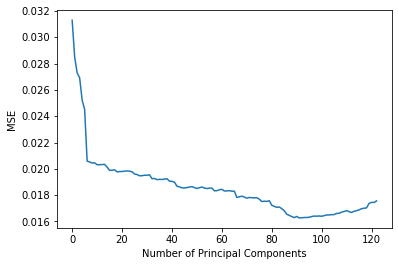

In [25]:
pca = PCA()
X_reduced_train = pca.fit_transform(X_train_standardized)
regr = LinearRegression()
cv_mse = []
for i in range(1,124):
    cv_score = -cross_val_score(regr, X_reduced_train[:,:i], y_train, cv=5, scoring='neg_mean_squared_error').mean()
    #print(i,' ', cv_score)
    cv_mse.append(cv_score)
plt.plot(cv_mse)
plt.xlabel('Number of Principal Components')
plt.ylabel('MSE')
print('M =', cv_mse.index(min(cv_mse))+1)
print('CV MSE = ', min(cv_mse))

In [26]:
X_reduced_test = pca.transform(X_test_standardized)[:, :92]
regr = LinearRegression()
regr.fit(X_reduced_train[:,:92], y_train)

pred = regr.predict(X_reduced_test)
print('test MSE for PCR wiz M = 92:', mean_squared_error(y_test, pred))

test MSE for PCR wiz M = 92: 0.016784686382359554


#### 2(j) In this section, we would like to fit a boosting tree to the data. As in classification trees, one can use any type of regression at each node to build a multivariate regression tree. Because the number of variables is large in this problem, one can use L1-penalized regression at each node. Such a tree is called L1 penalized gradient boosting tree. You can use XGBoost5 to fit the model tree. Determine α (the regularization term) using cross-validation.

In [27]:
min_mse = 1
best_alpha = -1
for potential_alpha in np.linspace(0, 5, num=41):
    xgbr = XGBRegressor(reg_alpha=potential_alpha)
    cv_score = -cross_val_score(xgbr, X_train_standardized, y_train, cv=5, scoring='neg_mean_squared_error').mean()
    #print(potential_alpha,' ', cv_score)
    if cv_score < min_mse:
        min_mse = cv_score
        best_alpha = potential_alpha

print('XGB minimum CV MSE =', min_mse)
print('Obtained when alpha =', best_alpha)

XGB minimum CV MSE = 0.018551857528401362
Obtained when alpha = 4.0


In [28]:
xgbr = XGBRegressor(alpha=best_alpha)
xgbr.fit(X_train_standardized, y_train)
xgb_pred = xgbr.predict(X_test_standardized)
print('test MSE for XGB:', mean_squared_error(y_test, xgb_pred))

test MSE for XGB: 0.017326327158050582
